In [142]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

from tqdm import tqdm
from itertools import combinations
from hurst import compute_Hc
from arch.unitroot import engle_granger
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from statsmodels.tsa.stattools import coint
import statsmodels.api as sm

In [4]:
price_df = pd.read_csv('./data/us_etf_price.csv')

In [5]:
price_df = price_df.astype({'Date': 'datetime64[ns]'})

In [6]:
price_df['year'] = price_df['Date'].apply(lambda x: x.year)
price_df['month'] = price_df['Date'].apply(lambda x: x.month)

In [8]:
# formation = price_df[(price_df.year == 2022) & ((price_df.month == 1) | (price_df.month == 2) | (price_df.month == 3))]
# formation = formation.set_index('Date')
# formation_etf_list = list(formation[formation.index == '2022-01-03'].tic.unique())

formation = price_df[(price_df.Date>='2010-01-01') & (price_df.Date<'2011-01-01')]
formation = formation.set_index('Date')
formation_etf_list = list(formation[formation.index == formation.index[0]].tic.unique())

In [9]:
formation

,Open,High,Low,Close,Adj Close,Volume,tic,year,month
Date,,,,,,,,,
2010-01-04,53.470001,53.950001,53.389999,53.860001,40.110847,904100.0,IVE,2010,1
2010-01-05,53.930000,54.180000,53.750000,54.150002,40.326817,682300.0,IVE,2010,1
2010-01-06,54.119999,54.400002,54.070000,54.279999,40.423626,675600.0,IVE,2010,1
2010-01-07,54.270000,54.840000,54.130001,54.750000,40.773643,591800.0,IVE,2010,1
2010-01-08,54.680000,54.860001,54.540001,54.849998,40.848118,351400.0,IVE,2010,1
...,...,...,...,...,...,...,...,...,...
2010-12-27,21.450001,21.540001,21.389999,21.500000,16.015892,101300.0,EWO,2010,12
2010-12-28,21.809999,21.809999,21.549999,21.590000,16.082933,49200.0,EWO,2010,12
2010-12-29,21.830000,22.070000,21.830000,21.990000,16.380911,162600.0,EWO,2010,12


In [10]:
len(formation_etf_list)

456

In [11]:
close_df = pd.DataFrame(index = formation.index.unique())

for x in tqdm(formation_etf_list):
    tmp = test = formation['Close'][formation.tic == x]
    close_df = pd.concat([close_df, tmp], axis=1)

close_df.columns = formation_etf_list

100%|██████████| 456/456 [00:04<00:00, 108.70it/s]


In [12]:
close_df

,IVE,ERTH,SPXS,RYF,QQXT,RFV,FXN,RWJ,FDD,DOG,...,DSI,IGE,PJP,IYW,RBLD,FAZ,TOK,XHB,XLE,EWO
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-04,53.860001,25.000000,20325.0,16.326817,17.940001,28.750000,17.350000,26.660000,14.49,206.240005,...,21.639999,35.450001,18.900000,14.622500,39.419998,59008.0,37.480000,15.320000,58.810001,20.200001
2010-01-05,54.150002,25.100000,20137.5,16.312849,17.969999,28.889999,17.650000,26.540001,14.47,206.440002,...,21.674999,35.810001,18.780001,14.600000,39.830002,56704.0,37.520000,15.430000,59.290001,20.700001
2010-01-06,54.279999,25.389999,20050.0,16.592178,18.020000,29.280001,18.010000,26.520000,14.50,206.320007,...,21.660000,36.270000,18.760000,14.497500,40.490002,56352.0,37.650002,15.510000,60.000000,20.650000
2010-01-07,54.750000,25.480000,19800.0,16.871508,18.090000,29.490000,17.930000,26.790001,14.45,205.479996,...,21.735001,36.080002,18.790001,14.442500,40.650002,53184.0,37.639999,16.150000,59.910000,20.680000
2010-01-08,54.849998,25.600000,19587.5,16.752792,18.209999,29.700001,18.170000,26.889999,14.45,205.360001,...,21.855000,36.400002,18.809999,14.552500,41.279999,53792.0,37.770000,16.219999,60.299999,20.680000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2010-12-27,59.520000,26.370001,11012.5,19.532124,21.020000,34.110001,20.830000,32.959999,13.42,177.800003,...,23.495001,40.880001,23.980000,16.145000,43.799999,30048.0,39.889999,17.610001,67.169998,21.500000
2010-12-28,59.639999,26.240000,11000.0,19.504190,21.090000,34.040001,20.879999,32.930000,13.38,177.360001,...,23.514999,41.180000,23.879999,16.147499,44.020000,29984.0,39.860001,17.430000,67.419998,21.590000
2010-12-29,59.650002,26.510000,10950.0,19.511173,21.219999,34.200001,21.129999,32.919998,13.71,177.240005,...,23.504999,41.560001,23.900000,16.165001,44.610001,30144.0,39.980000,17.420000,68.089996,21.990000


In [13]:
rtn_df = close_df.pct_change()[1:]

In [14]:
rtn_df_scaled = pd.DataFrame(StandardScaler().fit_transform(rtn_df))

In [15]:
pca = PCA()
pca.fit(rtn_df_scaled)
cumsum_eigen_value = np.cumsum(pca.explained_variance_ratio_)
pca_components = pca.components_[:np.where(cumsum_eigen_value >= 0.9)[0][0]]

pc_rtn = pd.DataFrame(data=pca_components.T, index=rtn_df.columns)
pc_rtn = pc_rtn.add_prefix("P")
pc_rtn

,P0,P1,P2,P3,P4,P5,P6
IVE,0.050457,-0.010388,-0.015418,0.015423,-0.087908,-0.012974,0.031737
ERTH,0.049624,0.012606,-0.006851,0.029204,0.045184,-0.004910,-0.045389
SPXS,-0.051322,0.014020,0.005324,-0.016109,0.039105,-0.021996,-0.025722
RYF,0.045174,-0.031227,-0.001495,-0.002672,-0.084256,-0.092181,-0.008373
QQXT,0.047966,-0.040450,-0.018374,-0.034328,0.042957,0.020393,0.011326
...,...,...,...,...,...,...,...
FAZ,-0.047209,0.017136,-0.015495,-0.082441,0.140960,0.073630,-0.043544
TOK,0.048614,0.021675,-0.043277,-0.017324,0.004387,-0.001447,-0.048225
XHB,0.044008,-0.047919,0.042542,0.022880,-0.005663,-0.090182,-0.051286
XLE,0.047933,0.024726,0.053231,-0.036753,-0.076237,0.103960,-0.068068


In [16]:
data = StandardScaler().fit_transform(pc_rtn)

In [21]:
data.shape

(456, 7)

## K-Means

In [23]:
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings("ignore")

In [24]:
# WCSS = Within Cluster Sum of Square
# WCSS: Sum of squared distance btwn each point and the centroid in a cluster.

wcss = []

for i in tqdm(range(1,21)):
    kmeans_pca = KMeans(n_clusters=i, init = 'k-means++', random_state=2022)
    kmeans_pca.fit(data)
    wcss.append(kmeans_pca.inertia_)

100%|██████████| 20/20 [00:06<00:00,  3.33it/s]


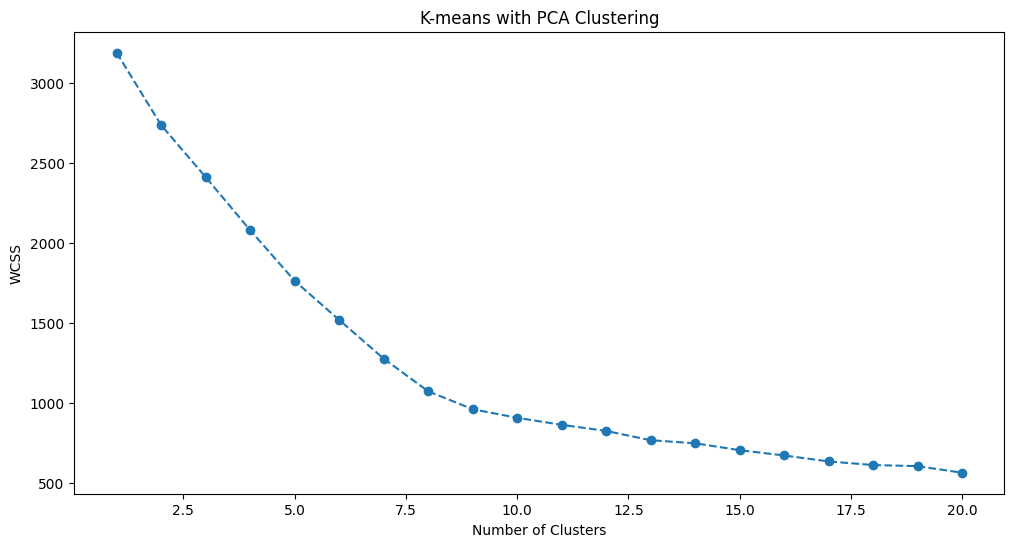

In [25]:
# Elbow-method를 적용하기 위한 plot
# 박찬주 논문에서도 휴리스틱하게 엘보우 기법으로 K를 결정

plt.figure(figsize=(12,6))
plt.plot(range(1,21), wcss, marker='o', linestyle='--')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.title('K-means with PCA Clustering')
plt.show()

In [26]:
# cluster의 수가 정해진 다음 K-means를 적용합니다.
# 여기서는 ' 8 ' 로 지정해보았습니다.
n_clusters=8

kmeans_pca = KMeans(n_clusters = n_clusters, init = 'k-means++', random_state=2022)
kmeans_pca.fit(data)

KMeans(random_state=2022)

In [55]:
# K-means clustering with PCA results
# score_pca에 담긴 pca components' score를 각각 이름붙여 column 형태로 저장해봅니다.
# PCA가 3개이므로, components는 3개를 추가하게 됩니다. 데이터프레임의 마지막 열에는 군집의 번호가 부여됩니다.

df_segm_pca_kmeans = pd.concat([pd.DataFrame(close_df.columns),pd.DataFrame(data)], axis=1)
df_segm_pca_kmeans.columns = ['ticker', 'P0', 'P1', 'P2', 'P3', 'P4', 'P5', 'P6']
df_segm_pca_kmeans['Segment_K-means_PCA'] = kmeans_pca.labels_
df_segm_pca_kmeans = df_segm_pca_kmeans.set_index('ticker')

In [56]:
df_segm_pca_kmeans

,P0,P1,P2,P3,P4,P5,P6,Segment_K-means_PCA
ticker,,,,,,,,
IVE,0.448706,-0.243115,-0.300693,0.407066,-1.932986,-0.244325,0.729739,0
ERTH,0.417453,0.248002,-0.117678,0.702219,0.913094,-0.072041,-0.919387,2
SPXS,-3.366138,0.278220,0.142403,-0.268262,0.783090,-0.437097,-0.498852,5
RYF,0.250688,-0.688210,-0.003269,0.019520,-1.854889,-1.936647,-0.127897,0
QQXT,0.355340,-0.885223,-0.363860,-0.658457,0.865476,0.468583,0.293314,4
...,...,...,...,...,...,...,...,...
FAZ,-3.211992,0.344762,-0.302341,-1.688891,2.961200,1.606016,-0.879935,5
TOK,0.379628,0.441721,-0.895857,-0.294266,0.040682,0.001959,-0.980009,2
XHB,0.206977,-1.044751,0.937489,0.566775,-0.174237,-1.893924,-1.045468,3


In [70]:
# 시각화를 위해 새로운 컬럼을 추가합니다.

df_segm_pca_kmeans['Segment'] = df_segm_pca_kmeans['Segment_K-means_PCA'].map({
    0:'group1', 1:'group2', 2:'group3', 3:'group4', 4:'group5', 5:'group6', 6:'group7', 7:'group8'
})

In [71]:
df_segm_pca_kmeans.head()

,P0,P1,P2,P3,P4,P5,P6,Segment_K-means_PCA,Segment
ticker,,,,,,,,,
IVE,0.448706,-0.243115,-0.300693,0.407066,-1.932986,-0.244325,0.729739,0,group1
ERTH,0.417453,0.248002,-0.117678,0.702219,0.913094,-0.072041,-0.919387,2,group3
SPXS,-3.366138,0.278220,0.142403,-0.268262,0.783090,-0.437097,-0.498852,5,group6
RYF,0.250688,-0.688210,-0.003269,0.019520,-1.854889,-1.936647,-0.127897,0,group1
QQXT,0.355340,-0.885223,-0.363860,-0.658457,0.865476,0.468583,0.293314,4,group5


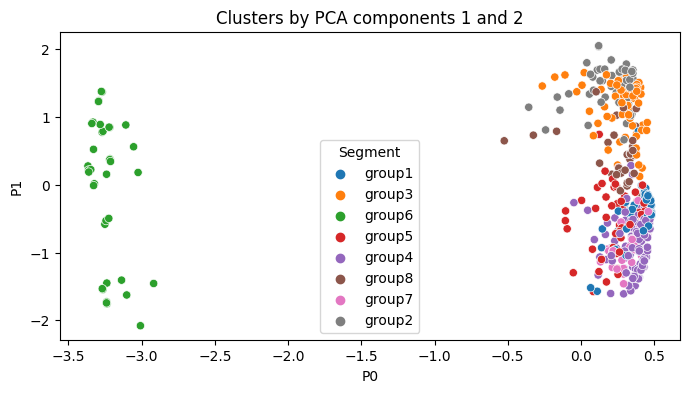

In [72]:
x_axis = df_segm_pca_kmeans['P0']
y_axis = df_segm_pca_kmeans['P1']

plt.figure(figsize=(8,4))
sns.scatterplot(x_axis, y_axis, hue = df_segm_pca_kmeans['Segment'])
plt.title('Clusters by PCA components 1 and 2')
plt.show()

Segment
group1     58
group2     50
group3     76
group4    106
group5     54
group6     39
group7     38
group8     35
Name: Segment_K-means_PCA, dtype: int64


<AxesSubplot:xlabel='Segment'>

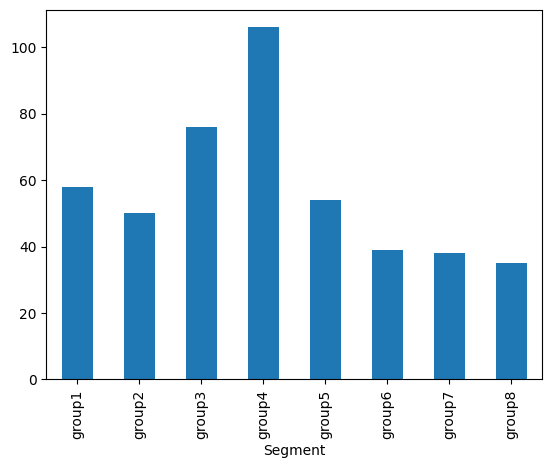

In [75]:
# cluster 분포 확인
K_cluster_size = df_segm_pca_kmeans['Segment'].value_counts()
K_cluster_size = df_segm_pca_kmeans.groupby(['Segment'])['Segment_K-means_PCA'].count()
print(K_cluster_size)
K_cluster_size.plot(kind='bar')

<AxesSubplot:ylabel='Segment'>

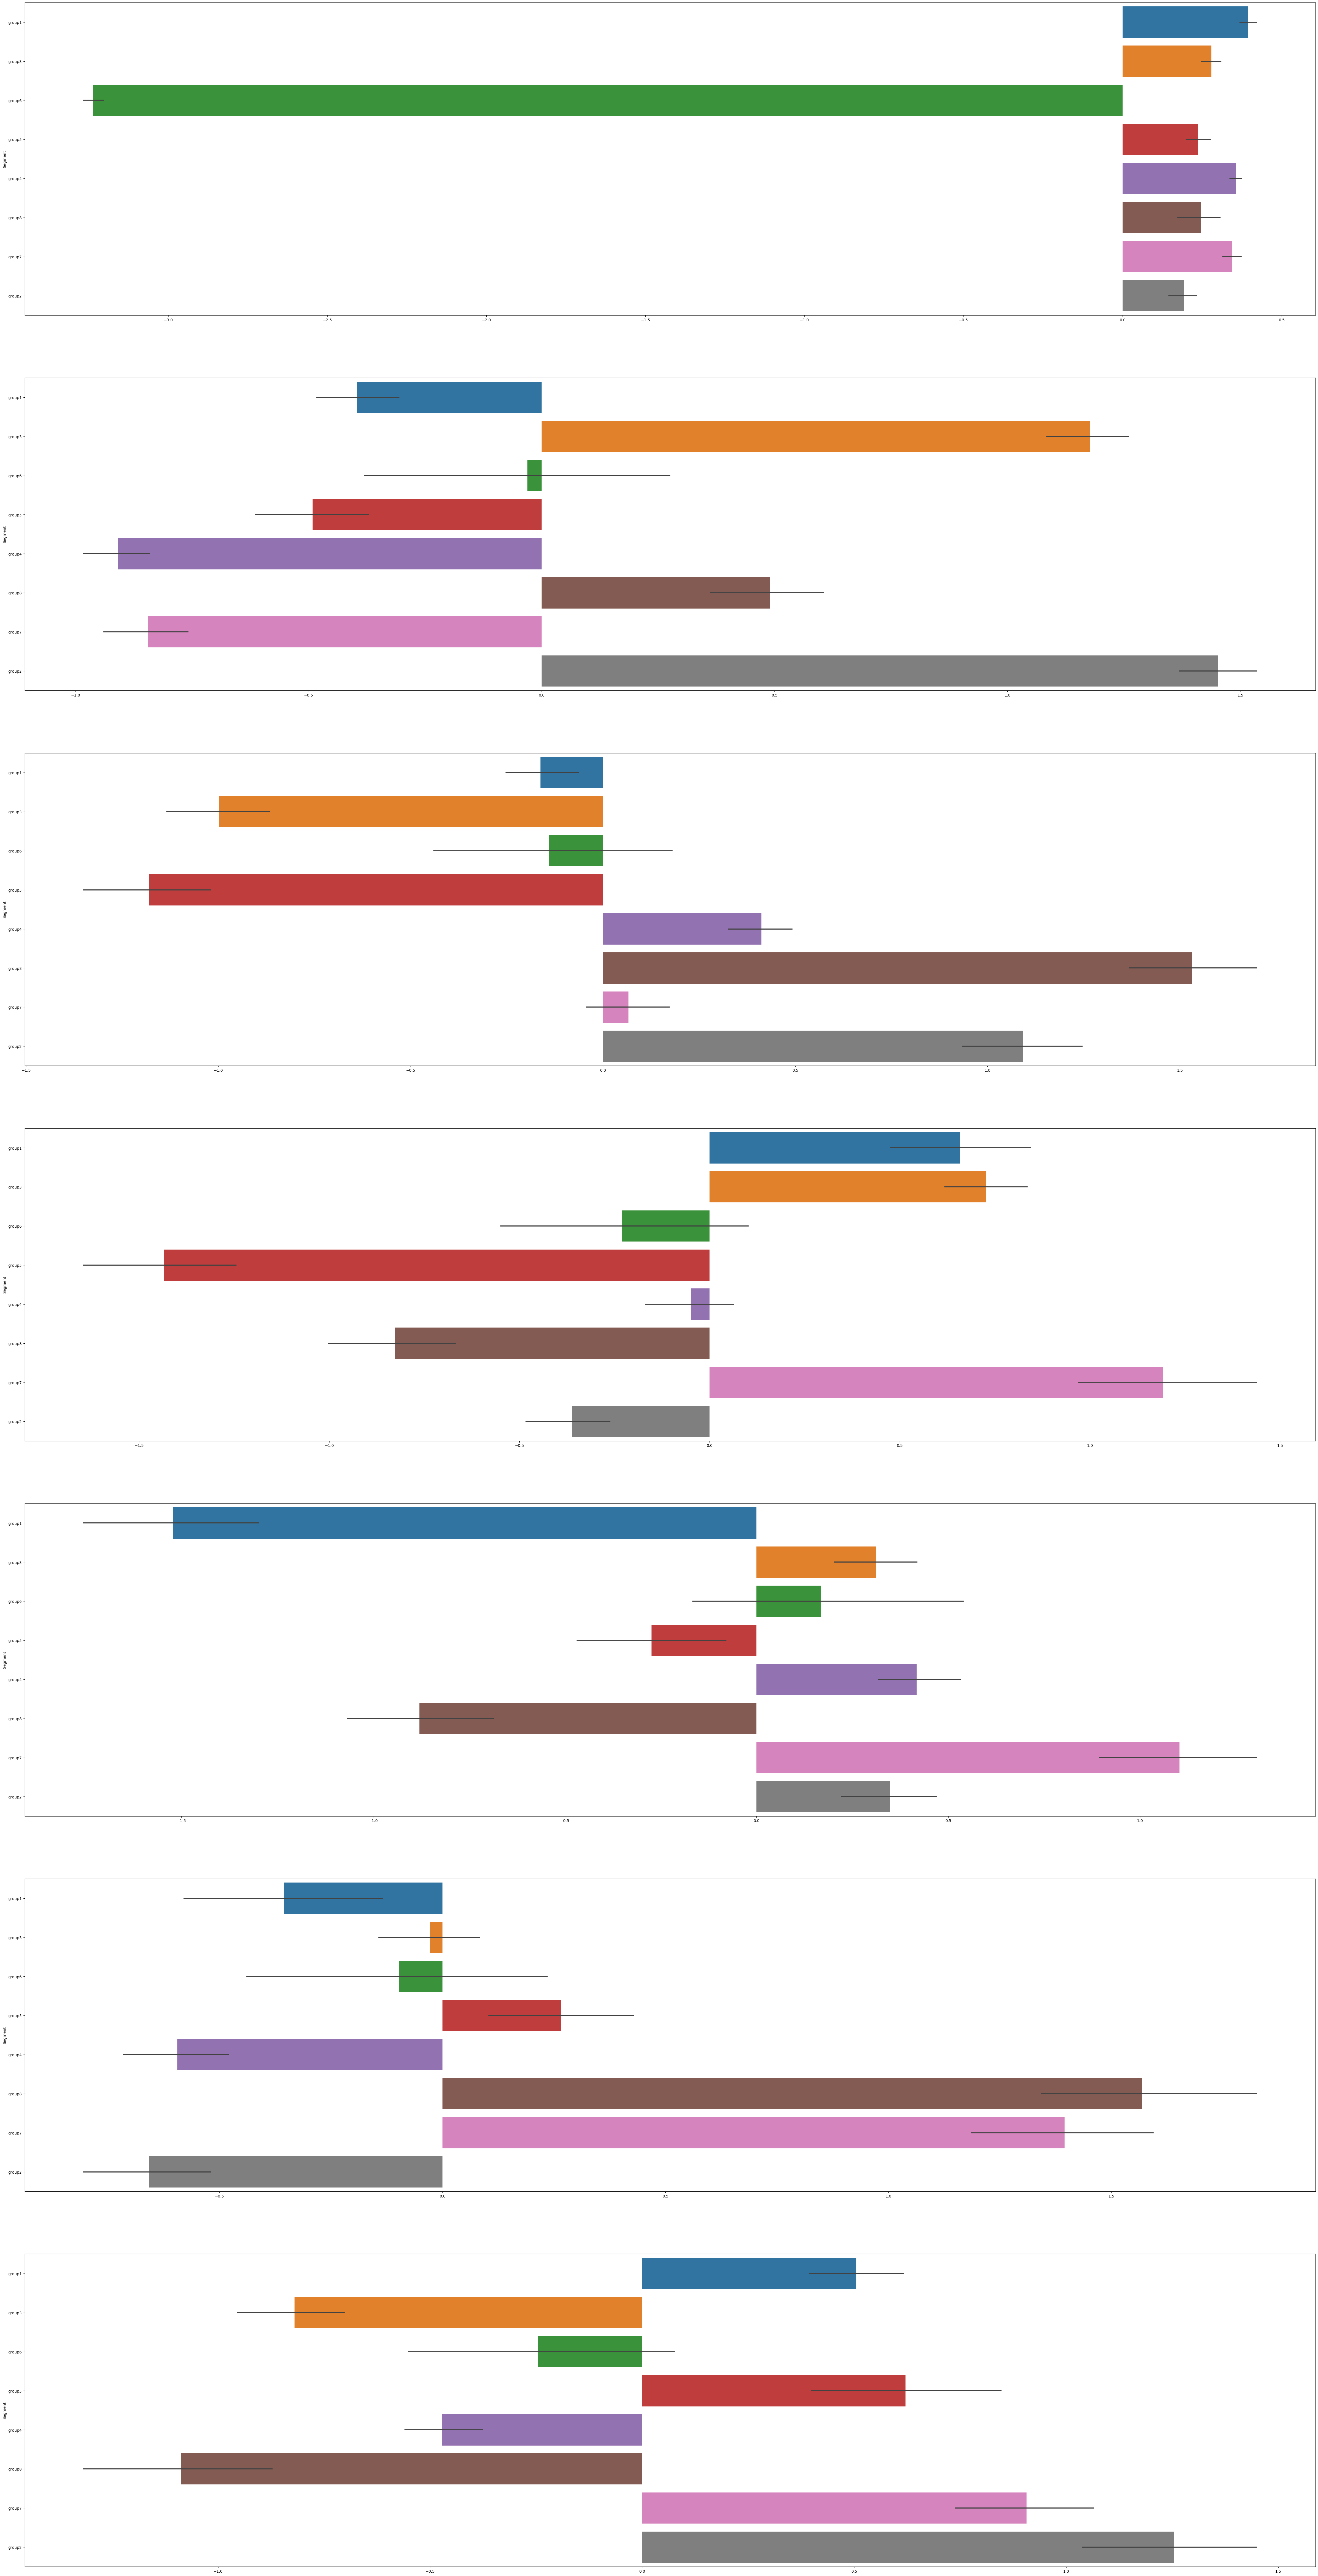

In [91]:
# 클러스터 전반적 특성 확인하기
# PCA변수 7개, cluster 8개

figure, ((ax1,ax2,ax3,ax4,ax5,ax6,ax7)) = plt.subplots(nrows=7, ncols=1)
figure.set_size_inches(60,120)

sns.barplot(data=df_segm_pca_kmeans, y=df_segm_pca_kmeans['Segment'], x=df_segm_pca_kmeans['P0'].values, orient='h', ax=ax1)

sns.barplot(data=df_segm_pca_kmeans, y=df_segm_pca_kmeans['Segment'], x=df_segm_pca_kmeans['P1'].values, orient='h', ax=ax2)

sns.barplot(data=df_segm_pca_kmeans, y=df_segm_pca_kmeans['Segment'], x=df_segm_pca_kmeans['P2'].values, orient='h', ax=ax3)

sns.barplot(data=df_segm_pca_kmeans, y=df_segm_pca_kmeans['Segment'], x=df_segm_pca_kmeans['P3'].values, orient='h', ax=ax4)

sns.barplot(data=df_segm_pca_kmeans, y=df_segm_pca_kmeans['Segment'], x=df_segm_pca_kmeans['P4'].values, orient='h', ax=ax5)

sns.barplot(data=df_segm_pca_kmeans, y=df_segm_pca_kmeans['Segment'], x=df_segm_pca_kmeans['P5'].values, orient='h', ax=ax6)

sns.barplot(data=df_segm_pca_kmeans, y=df_segm_pca_kmeans['Segment'], x=df_segm_pca_kmeans['P6'].values, orient='h', ax=ax7)


['group2',
 'group6',
 'group4',
 'group1',
 'group3',
 'group7',
 'group5',
 'group8']

In [113]:
clustered_series = df_segm_pca_kmeans.reset_index()[['ticker','Segment']]
clusters_viz_list = list(set(df_segm_pca_kmeans['Segment']))

In [137]:
df_segm_pca_kmeans['Segment'].isna().sum()

0

In [124]:
clustered_series[clustered_series['Segment']=='group1'].ticker.values

array(['IVE', 'RYF', 'VFH', 'RWL', 'FXO', 'RPV', 'DLN', 'IWV', 'SPY',
       'MGC', 'ITOT', 'SPXL', 'XLF', 'SPYV', 'DIA', 'IYY', 'OEF', 'IWD',
       'UYG', 'FAS', 'IYF', 'IVV', 'IWX', 'PRF', 'DDM', 'CSM', 'IUSV',
       'IAT', 'IAK', 'KBE', 'IYG', 'ILCB', 'QABA', 'KRE', 'VTI', 'IXG',
       'XLG', 'PWV', 'SCHX', 'IWB', 'MGV', 'RTH', 'SUSA', 'UPRO', 'IAI',
       'KIE', 'SCHB', 'VV', 'VTV', 'SSO', 'KCE', 'PEY', 'ILCV', 'RSP',
       'VOE', 'SCHV', 'VYM', 'DSI'], dtype=object)

In [129]:
close_df.T.loc['IVE',].T.mean()

54.69388892158629

<Figure size 1000x500 with 0 Axes>

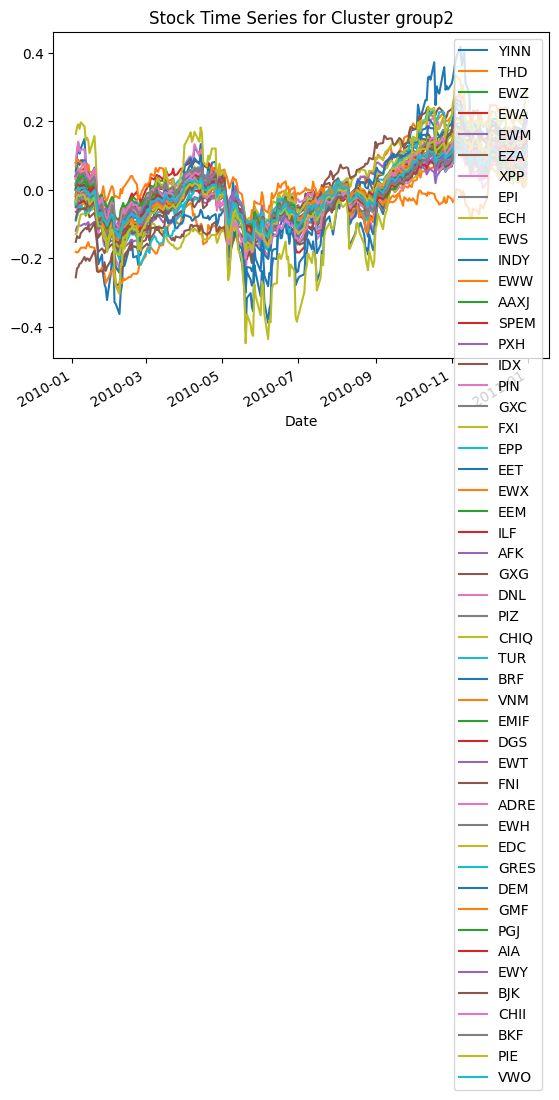

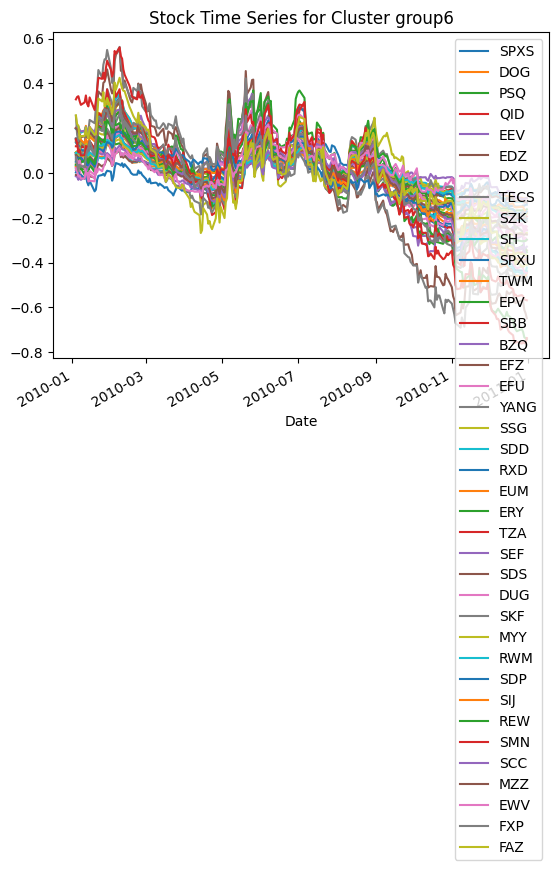

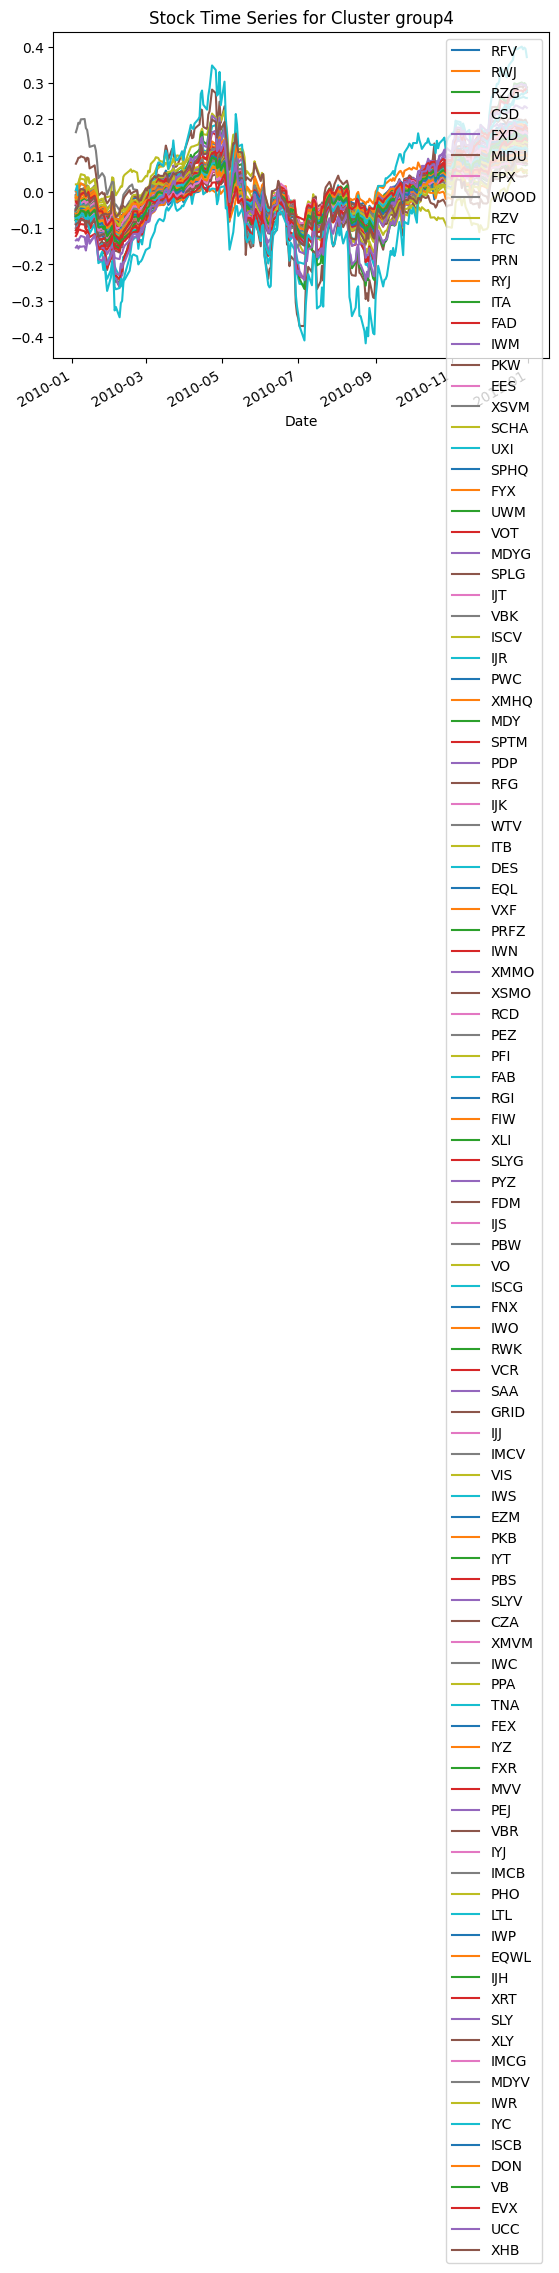

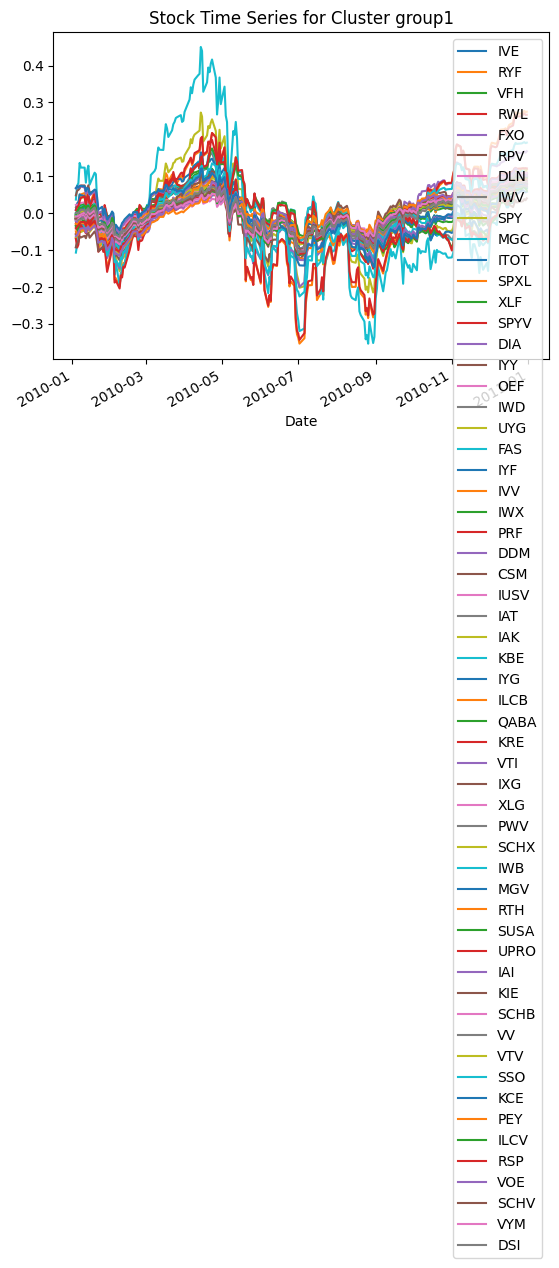

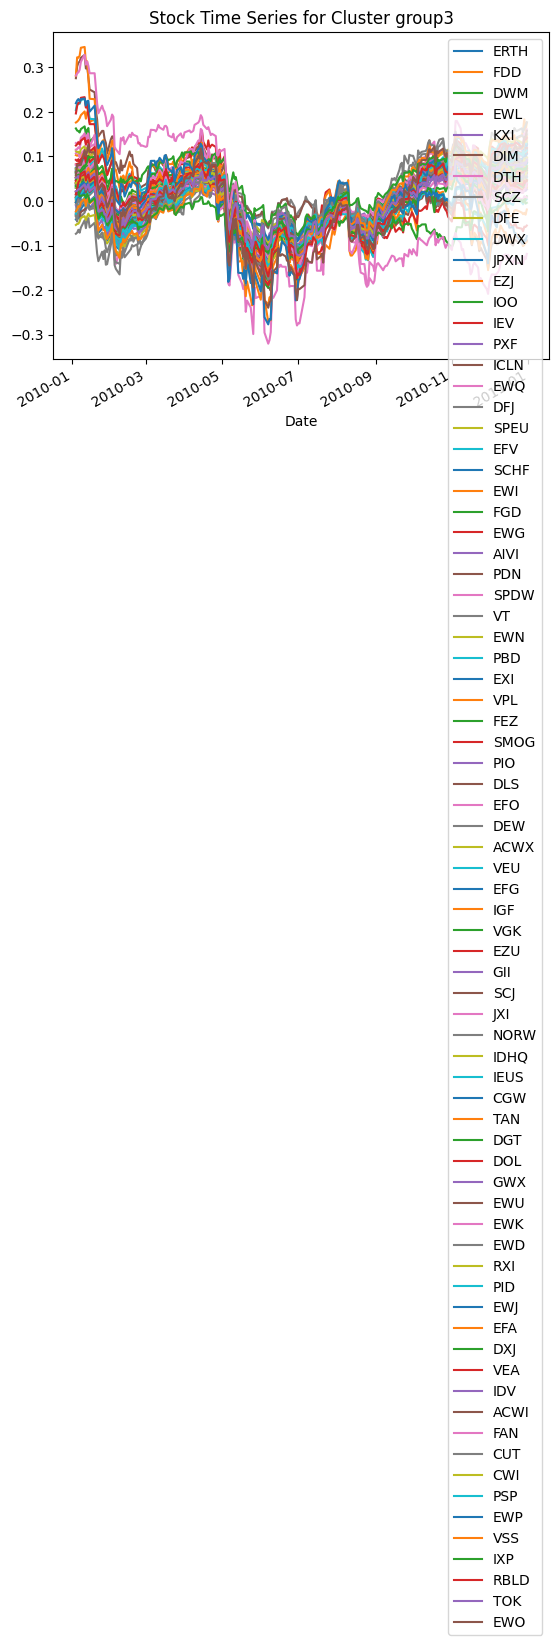

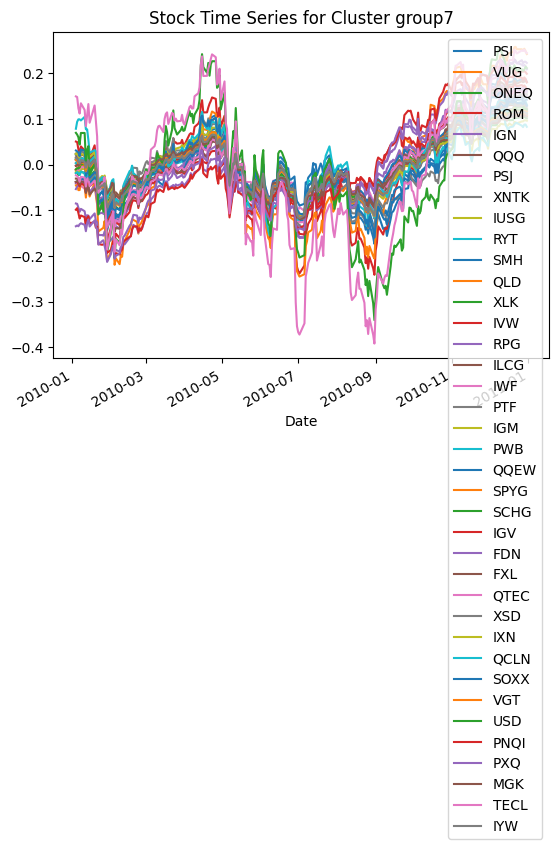

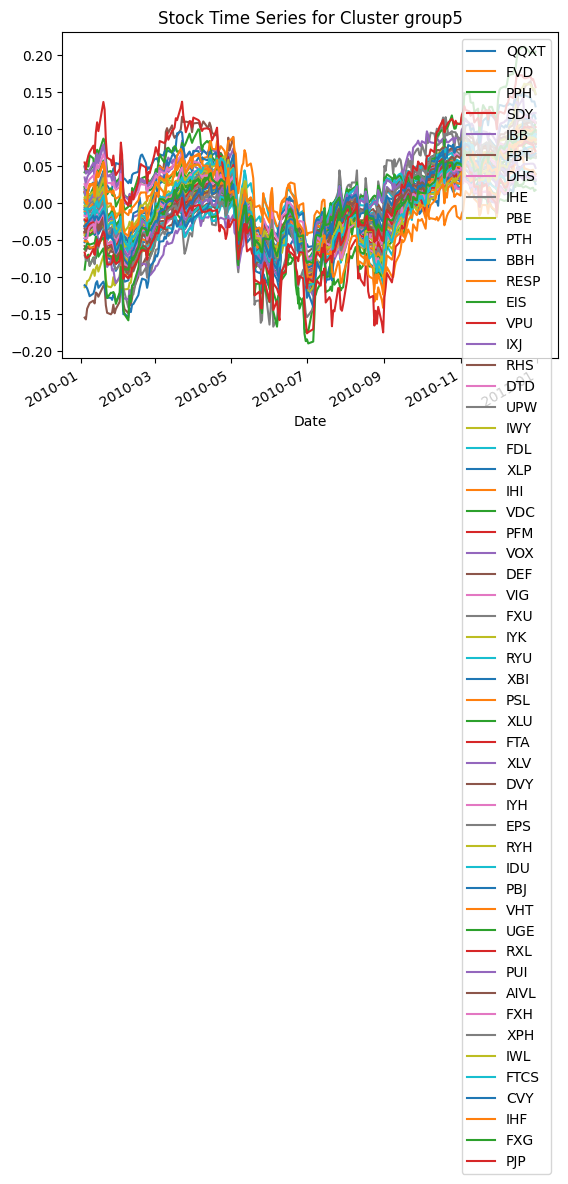

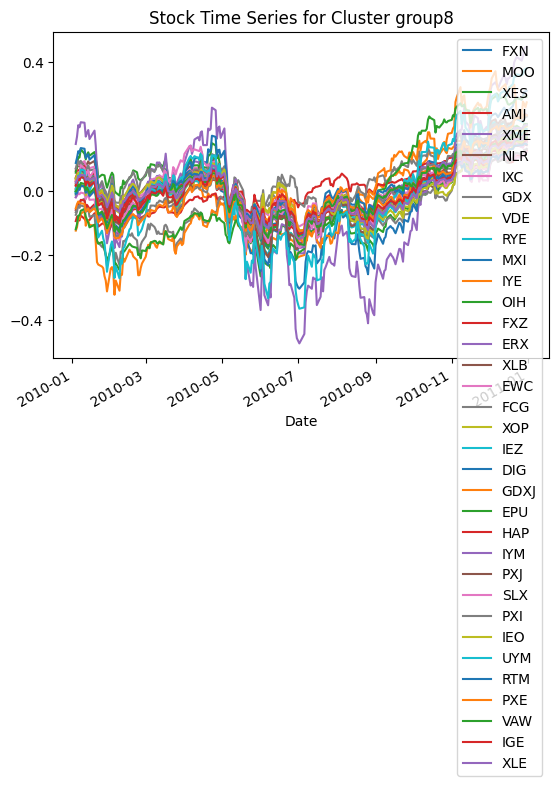

In [133]:
plt.figure(figsize=(10,5))
for c in clusters_viz_list:
    stocks = list(clustered_series[clustered_series['Segment']==c].ticker.values)
    means = np.log(close_df.T.loc[stocks,].T.mean())
    data = np.log(close_df.T.loc[stocks,]).T.sub(means)
    data.plot(title='Stock Time Series for Cluster {}'.format(c))
    plt.savefig('stock_price_clsuter_'+str(c)+'.png')
    plt.show()

이 다음은 모르겟쑤요.

### Pair Selection

In [140]:
etf_info = pd.read_csv('./data/etf_list/etfs_details_equity.csv')
etf_info['volume'] = etf_info['Avg. Daily Volume'].str.replace(',','').astype('float')
low_volume_etf = etf_info[etf_info.volume < etf_info.volume.quantile(0.1)].Symbol.to_list()

In [148]:
clustered_series = clustered_series.set_index('ticker')

In [149]:
def Pair_selection(clusters_viz_list, inverse_threshold, coint_pvalue_threshold, hurst_threshold, half_life_threshold, mean_reverting_freq):
    
    selected_pair = []
    for i in tqdm(range(len(clusters_viz_list))):
        test_list = list(clustered_series[clustered_series == clusters_viz_list[i]].index)

        # 1. 거래량 10분위 이하 제거
        vol_screened_test_list = []
        for x in test_list:
            if (x in low_volume_etf) == False:
                vol_screened_test_list.append(x)       
                
        # 2. corr -0.99 보다 작은 etf가 존재하는지 -> 숏포지션 잡을 수 있는지 여부
        short_avail_test_list = []
        for x in vol_screened_test_list:
            if rtn_df.corr()[x].min() < inverse_threshold:
                short_avail_test_list.append(x)
                
        # 3. Cointegration - pvalue 0.05 이하인 pair sorting
        log_price_data = np.log(close_df[short_avail_test_list])
        comb = list(combinations(short_avail_test_list, 2))
        eg_pvalue = {}

        for x in comb:
            score, pvalue, _ = coint(log_price_data[x[0]], log_price_data[x[1]], method='aeg')
            eg_pvalue[x] = pvalue

        possible_pair = [x[0] for x in sorted(eg_pvalue.items(), key=lambda item: item[1]) if x[1] <= coint_pvalue_threshold]

        # 4. Hurst exponent test - mean reverting intensity : H < 0.5 이하인 종목 선정
        spread_df = pd.DataFrame(index = log_price_data.index)

        for x in possible_pair:
            spread_df[x] = close_df[x[0]] - close_df[x[1]]
        
        hurst_screened_list = []

        for cnd in possible_pair:
            if compute_Hc(spread_df[cnd])[0] <= hurst_threshold:
                hurst_screened_list.append(cnd)

        spread_df = spread_df[hurst_screened_list]

        # 5. Half life가 trading period 안에 들어오는 종목 스크리닝
        spread_df_lag = spread_df.shift(1)
        spread_df_diff = spread_df - spread_df_lag

        hl_screened_list = []
        for i in range(len(hurst_screened_list)):
            X = sm.add_constant(spread_df_lag.iloc[1:,i])
            model = sm.OLS(spread_df_diff.iloc[1:,i], X)
            result = model.fit()
            lamda = result.params[1]
            HL = -np.log(2) / lamda

        # trading period 고려
            if (HL <= half_life_threshold) & (HL >= 1):
                hl_screened_list.append(hurst_screened_list[i])

        spread_df = spread_df[hl_screened_list]

        # 6. mean-reverting freq이 충분히 자주 발생하는지 스크리닝
        freq_screened_list = []

        for j in range(len(spread_df.columns)):

            cnt = 0

            for i in range(len(spread_df.index)):

                if i == len(spread_df.index) -1:
                    break

                elif spread_df.iloc[i+1,j] >= spread_df.iloc[i,j]:
                    if (spread_df.mean()[j] >= spread_df.iloc[i,j]) & (spread_df.mean()[j] <= spread_df.iloc[i+1,j]):
                        cnt += 1

                else:
                    if (spread_df.mean()[j] >= spread_df.iloc[i+1,j]) & (spread_df.mean()[j] <= spread_df.iloc[i,j]):
                        cnt += 1
            
            if cnt >= mean_reverting_freq:
                freq_screened_list.append(hl_screened_list[j])

        selected_pair.append(freq_screened_list)

    return selected_pair

In [150]:
Pair_selection(clusters_viz_list=clusters_viz_list, inverse_threshold=0.1, coint_pvalue_threshold=0.05, hurst_threshold=0.5, half_life_threshold=30, mean_reverting_freq=12)

100%|██████████| 8/8 [8:00:29<00:00, 3603.65s/it]  


[[('ITOT', 'SPTM'),
  ('RGI', 'VIS'),
  ('SPDW', 'CWI'),
  ('SPY', 'IVV'),
  ('FXR', 'MVV'),
  ('VEU', 'EMIF'),
  ('PYZ', 'RXI'),
  ('QQQ', 'RXI'),
  ('EWC', 'QQEW'),
  ('IWV', 'VTI'),
  ('SPDW', 'VPL'),
  ('EMIF', 'PID'),
  ('EWS', 'RYU'),
  ('FGD', 'EMIF'),
  ('ILF', 'NORW'),
  ('AAXJ', 'SPEM'),
  ('PXH', 'NORW'),
  ('EWC', 'FEX'),
  ('PBE', 'EWC'),
  ('VPL', 'ACWI'),
  ('VDC', 'AFK'),
  ('IAT', 'KRE'),
  ('IDHQ', 'CWI'),
  ('IEV', 'IGF'),
  ('IXC', 'RYH'),
  ('DEF', 'IYZ'),
  ('EWL', 'EMIF'),
  ('EFG', 'EMIF'),
  ('IXC', 'EWJ'),
  ('FAB', 'FXR'),
  ('WOOD', 'AFK'),
  ('PFI', 'SCJ'),
  ('MDYG', 'IWP'),
  ('RYH', 'EWJ'),
  ('RHS', 'DON'),
  ('PBE', 'RTM'),
  ('SEF', 'SCJ'),
  ('RYT', 'SLYG'),
  ('DFE', 'EMIF'),
  ('EWZ', 'FGD'),
  ('RPV', 'SCJ'),
  ('PXF', 'IGF'),
  ('ILF', 'AFK'),
  ('EWZ', 'PID'),
  ('EPP', 'EMIF'),
  ('EWZ', 'EMIF'),
  ('DEF', 'PIE'),
  ('VBK', 'IWO'),
  ('PKW', 'XLK'),
  ('RGI', 'IWS'),
  ('PYZ', 'AIVL'),
  ('SZK', 'SMN'),
  ('DWM', 'DWX'),
  ('ILF', 'DEM'),
  ('I